In [ ]:
!pip install opencv-python
!pip install paddleocr
!pip install paddlepaddle
!pip install easyocr
!pip install boto3
!pip install --upgrade setuptools
!pip install --no-cache-dir paddleocr
!python -m pip install paddlepaddle-gpu==2.5.0.post118 -f
!pip install paddlepaddle
!pip install paddleocr
!pip install --upgrade setuptools
!pip install transformers
!pip install --upgrade transformers
!pip install pytesseract
!pip install --upgrade jupyterlab ipython

!pip install setuptools==65.5.0
!pip install fire
!pip install paddleocr

!pip install python-multipart opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=84210c3dbe21c8fdd5c1a8ca62ffffca8decddc795b9e5130e99e0c400e6469b
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found e


Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

-f option requires 1 argument
ERROR: Operation cancelled by user
^C
^C
^C
^C


# Image Conversion

In [1]:
from PIL import Image
import cv2
import numpy as np
import json
import cv2
from paddleocr import PaddleOCR
import numpy as np
from matplotlib import pyplot as plt

# Increase the limit to handle large images
Image.MAX_IMAGE_PIXELS = None

In [2]:
def resize_to_resolution(img_path, output_image_path, resolution):
    # Open the image file
    with Image.open(img_path) as img:
        # Get original dimensions
        original_width, original_height = img.size
        # print(f"Original size: {img.size}")

        # Get target resolution dimensions
        target_width, target_height = resolution

        # Calculate aspect ratio
        aspect_ratio = original_width / original_height

        # Adjust resolution to maintain aspect ratio
        if original_width > original_height:
            # Fit width to target and adjust height
            new_width = target_width
            new_height = int(target_width / aspect_ratio)
        else:
            # Fit height to target and adjust width
            new_height = target_height
            new_width = int(target_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Save the resized image
        resized_img.save(output_image_path)
        # print(f"Resized image to: {resized_img.size}")
        # print(f"Image saved to {output_image_path}")

        # Show the resized image
        # resized_img.show()
    return output_image_path


In [18]:
#denoising the image

# Load the compressed image
def denoise_image(path):
    image = cv2.imread(path)

    # Check if the image was successfully loaded
    if image is None:
        print("Error: Unable to open/read image file. Check the file path and integrity.")
    else:
        # Apply Non-Local Means Denoising (correct parameters)
        # Parameters: (source, h strength, template window size, search window size)
        denoised_image_nlmeans = cv2.fastNlMeansDenoisingColored(image, h=10, templateWindowSize=7, searchWindowSize=21)

        # Apply bilateral filter for stronger noise reduction without blurring the edges
        # Parameters: (source, filter size, sigma for color space, sigma for coordinate space)
        denoised_image_bilateral = cv2.bilateralFilter(denoised_image_nlmeans, d=9, sigmaColor=100, sigmaSpace=100)

        # Apply sharpening kernel to bring back some clarity after denoising
        sharpening_kernel = np.array([[0, -1, 0],
                                    [-1, 5, -1],
                                    [0, -1, 0]])

        # Sharpen the image after denoising
        sharpened_image = cv2.filter2D(denoised_image_bilateral, -1, sharpening_kernel)

        # Convert the image to grayscale for contrast enhancement
        gray_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2GRAY)

        # Use histogram equalization to improve contrast
        equalized_image = cv2.equalizeHist(gray_image)

        # Convert back to BGR to save as color image
        final_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)
        enhanced_image_path = "enhanced_image_denoised.jpg"
        # Save the enhanced image without increasing pixel dimensions
        cv2.imwrite(enhanced_image_path, final_image)
        # print("Image processing complete. The enhanced image has been saved.")
        return enhanced_image_path


In [19]:
def perform_ocr_and_get_json(img_path):

    # Initialize the PaddleOCR model for English
    ocr = PaddleOCR(use_angle_cls=True, lang='en')

    # Load the image
    img = cv2.imread(img_path)

    # Perform OCR on the image
    result = ocr.ocr(img_path, cls=True)

    # Function to group text boxes into rows based on y-coordinates
    def is_same_row(box1, box2, row_threshold=10):
        _, y1, _, y2 = box1[0][1], box1[2][1], box2[0][1], box2[2][1]
        return abs(y1 - y2) < row_threshold

    # Group the detected text into rows
    rows = []
    current_row = []
    for line in result[0]:
        box = line[0]      # Bounding box coordinates
        text = line[1][0]  # Detected text
        confidence = line[1][1]

        if current_row and not is_same_row(current_row[-1][0], box):
            rows.append(current_row)
            current_row = []

        current_row.append((box, text, confidence))

    if current_row:
        rows.append(current_row)

    # Sort each row by the x-coordinate for left-to-right reading
    for row in rows:
        row.sort(key=lambda x: x[0][0][0])

    # Dynamically extract column headers from the first row
    column_headers = [item[1] for item in rows[0]]  # Extract text values from the first row

    # Convert subsequent rows into structured data
    data = []
    for row in rows[1:]:  # Skip the first row, as it's the header
        row_data = {}
        for i, (box, text, confidence) in enumerate(row):
            if i < len(column_headers):  # Ensure we don't exceed column count
                row_data[column_headers[i]] = {
                    "text": text,
                    "confidence": confidence,
                    "bounding_box": box  # Store the bounding box information
                }
        data.append(row_data)


    # Save the structured data with bounding box info as JSON
    json_file_path = './bounding_box_data_with_text.json'
    with open(json_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

    # print(f"Bounding box data saved as JSON: {json_file_path}")

    # (Optional) Visualize the detected text and bounding boxes
    boxes = [res[0] for res in result[0]]  # Bounding boxes for the detected text
    txts = [res[1][0] for res in result[0]]  # The recognized text
    scores = [res[1][1] for res in result[0]]  # Confidence scores

    # Draw results on the image and visualize
    image_with_boxes = cv2.polylines(img.copy(), [np.array(box).astype(int) for box in boxes], True, (0, 255, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    # image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    return json_file_path

In [11]:
def process_image_pipeline(img_path, output_image_path, resolution):
    try:
        resized_image_path = resize_to_resolution(img_path, output_image_path, resolution)
        print(f"Resized image saved at: {resized_image_path}")  # Log resized image path

        enhanced_image_path = denoise_image(resized_image_path)
        if enhanced_image_path:
            print(f"Denoised image saved at: {enhanced_image_path}")  # Log denoised image path
            json_file_path = perform_ocr_and_get_json(enhanced_image_path)
            print(f"JSON file generated at: {json_file_path}")  # Log JSON file path
            return json_file_path
        else:
            print("Error: Denoising failed.")  # Log denoising failure
            return {"error": "Image processing failed"}
    except Exception as e:
        print(f"Error in process_image_pipeline: {str(e)}")  # Log error in processing pipeline
        return {"error": str(e)}

In [6]:
from transformers import pipeline

def answer_question(context, question):
    """Performs question answering using a transformer-based model."""
    qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")

    response = qa_pipeline(question=question, context=context)
    return response["answer"]

# Example usage
if __name__ == "__main__":
    sample_context = "Transformers have revolutionized natural language processing."
    sample_question = "What have transformers revolutionized?"
    print(answer_question(sample_context, sample_question))

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


natural language processing


In [24]:
def main(img_path, output_image_path, resolution, question):
    """Runs the complete pipeline from image processing to question answering."""
    try:
        json_file_path = process_image_pipeline(img_path, output_image_path, resolution)

        if "error" in json_file_path:
            print("Error in processing image pipeline.")
            return json_file_path

        with open(json_file_path, "r") as file:
            ocr_data = json.load(file)

        context = " ".join([entry[col]["text"] for entry in ocr_data for col in entry])

        answer = answer_question(context, question)
        print(f"Answer: {answer}")
        return answer

    except Exception as e:
        print(f"Error in main function: {str(e)}")
        return {"error": str(e)}

# Example execution
if __name__ == "__main__":
    img_path = "/content/Screenshot 2024-09-03 184206.png"
    output_image_path = "output.png"
    resolution = (2000, 2000)
    question = "What is the size of semEval training dataset?"
    main(img_path, output_image_path, resolution, question)

Resized image saved at: output.png
Denoised image saved at: enhanced_image_denoised.jpg
[2025/03/08 15:40:01] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_i

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Answer: 2016 359 AM 18.341 2.042


In [21]:
if __name__ == "__main__":
    img_path = "/content/pexels-rdne-8363024.jpg"
    output_image_path = "output3.png"
    resolution = (2000, 2000)
    question = "What is natural?"
    main(img_path, output_image_path, resolution, question)

Resized image saved at: output3.png
Denoised image saved at: enhanced_image_denoised.jpg
[2025/03/08 15:32:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Answer: I'm a natural


**Display the results with bounding box**

In [25]:
import json

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

json_path = "/content/bounding_box_data_with_text.json"
with open(json_path, 'r') as f:
    data = json.load(f)

# 📌 Step 4: Draw Bounding Boxes
for item in data:
    mindset = item["MINDSET"]
    text = mindset["text"]
    bbox = np.array(mindset["bounding_box"], np.int32)  # Convert to numpy array

    # Draw Polygon (Bounding Box)
    cv2.polylines(image, [bbox], isClosed=True, color=(255, 0, 0), thickness=3)

    # Place Text near Bounding Box
    x, y = bbox[0]
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# 📌 Step 5: Display Image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

KeyError: 'MINDSET'

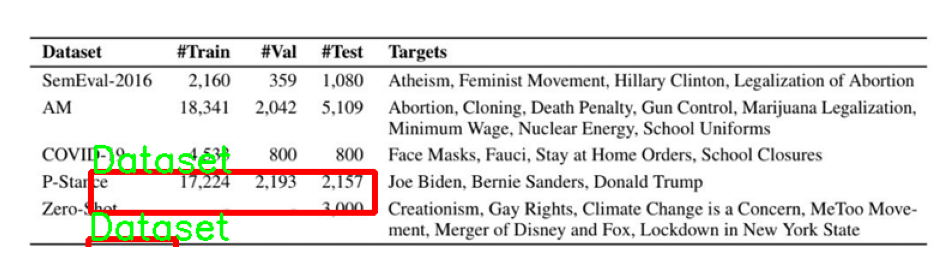

In [28]:
json_file = "/content/bounding_box_data_with_text.json"

image = cv2.imread("/content/Screenshot 2024-09-03 184206.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with open(json_file, 'r') as f:
  data = json.load(f)  # Load JSON file

for item in data:
  key = list(item.keys())[0]
  value = item[key]

        # Find bounding box dynamically
  bbox = None
  for k, v in value.items():
    if isinstance(v, list) and all(isinstance(i, list) and len(i) == 2 for i in v):
      bbox = np.array(v, np.int32)
      break  # Stop after finding the first valid bounding box

  if bbox is not None:
    # Draw Bounding Box
    cv2.polylines(image, [bbox], isClosed=True, color=(255, 0, 0), thickness=3)

    # Get Text Label Dynamically (If Available)
    text_label = key  # Use the JSON key as the label
    cv2.putText(image, text_label, tuple(bbox[0]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# 📌 Step 4: Display Final Image with All Bounding Boxes
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.show()